In [16]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy.fft as fft

In [17]:
root_dir = r"D:\A-deng\hunter\data"
#root_dir = r"D:\abc"
file_names = []

In [18]:
def list_dirs(root_dir):
    '''
    深度优先遍历文件夹，将文件夹下所有文件的路径存入file_names
    '''
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            file_names.append(os.path.join(root, file))

In [19]:
list_dirs(root_dir)
# file_names = file_names[0:1]

In [20]:
def read_data(file_names):
    '''
    传入所有数据文件，返回数据，数据形式[x, y, increment, data_size]
    '''
    datalist = []
    for file_name in file_names:
        if file_name.endswith('.csv'):
            print(f"Processing file: {file_name}")
            df = pd.read_csv(file_name)
            y = df['Math'].drop(df.index[0]).astype(float).to_numpy()
            x_start = df["Start"].iloc[0].astype(float)
            x_increment = df["Increment"].iloc[0].astype(float)
            data_size = len(y)
            x_end = x_increment * data_size
            x = np.arange(x_start, x_end, x_increment)
            datalist.append([x, y, x_increment, data_size])
        
    print(f"Length of datalist: {len(datalist)}")
    return datalist

In [21]:
data_list = read_data(file_names)
print(len(data_list))

Processing file: D:\A-deng\hunter\data\left_0\left_0_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_0\left_0_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_0\left_0_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_0\left_0_sensor2_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_180\left_180_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_180\left_180_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_180\left_180_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_180\left_180_sensor2_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_270\left_270_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_270\left_270_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_270\left_270_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_270\left_270_sensor2_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_90\left_90_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_90\left_90_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_90\left_90_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\left_90\left_90_sensor2_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_0\right_0_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_0\right_0_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_0\right_0_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_180\right_180-sensor2_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_180\right_180_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_180\right_180_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_180\right_180_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_270\right_270_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_270\right_270_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_270\right_270_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_270\right_270_sensor2_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_90\right_90_sensor1_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_90\right_90_sensor1_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_90\right_90_sensor2_ch12.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\hunter\data\right_90\right_90_sensor2_ch34.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_3676\4103129121.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Length of datalist: 31
31


In [22]:
print(len(data_list))

31


In [23]:
# FFT
def do_fft(y, increment, data_size):
    '''
    对y进行FFT变换，返回FFT结果和频率
    '''
    fft_result = fft.fft(y)
    fft_freq = fft.fftfreq(data_size, increment)
    return fft_result, fft_freq

In [24]:
fft_results = []
fft_freqs = []
params_b = []
fft_results_peaks=[]
phases = []

for data in data_list:
    fft_result, fft_freq = do_fft(data[1], data[2], data[3])
    fft_results.append(fft_result)
    fft_freqs.append(fft_freq)

    # 寻找FFT结果中的峰值
    peaks, _ = find_peaks(np.abs(fft_result), height=data[3]*0.01)  # height是选中阈值

    # 获取峰值的频率和振幅
    peak_frequencies = fft_freq[peaks]
    peak_amplitudes = np.abs(fft_result[peaks])
    fft_results_peaks.append(fft_result[peaks])
    print(fft_result[peaks])
    angles = np.angle(fft_result[peaks])

    b = 0
    # 打印峰值信息
    for i, frequency in enumerate(peak_frequencies):
        if frequency > 0:
            print(f"峰值 {i + 1}: 频率 = {frequency} Hz, 振幅 = {peak_amplitudes[i]}, 相位 = {angles[i]}")

            if 2 * np.pi * frequency > b:
                b = 2 * np.pi * frequency
                phase = angles[i]
    
    params_b.append(b)
    phases.append(phase)

[-421557.01909033-141102.98705809j -421557.01909033+141102.98705809j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 444545.1307809351, 相位 = -2.818595852554852
[310404.42266795+62334.33982169j 310404.42266795-62334.33982169j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 316601.4458792509, 相位 = 0.19818056379228763
[19513.37490144-150886.84787551j 19513.37490144+150886.84787551j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 152143.395064827, 相位 = -1.4421855967976573
[19080.13577972-144699.50902909j 19080.13577972+144699.50902909j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 145952.0451882493, 相位 = -1.439692273692229
[-260626.03908809+303927.73788464j -260626.03908809-303927.73788464j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 400372.32934660115, 相位 = 2.2796436205838413
[-236866.48942433+276501.2439129j -236866.48942433-276501.2439129j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 364086.07731906645, 相位 = 2.279141955630899
[-109833.2377065-33361.11727584j -109833.2377065+33361.11727584j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 114788.08409841158, 相位 = -2.8467051268466017
[-105014.99314312-32096.38252436j -105014.99314312+3209

In [25]:
# def fft_half(fft_result, increment):
#     '''
#     对FFT结果进行处理，返回FFT结果的一半和频率
#     '''
#     N = len(fft_result)
#     T = increment  # 采样间隔
#     xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

#     fft_result = fft_result[:N//2]
#     return fft_result, xf

In [26]:
# fft_half_result, xf = fft_half(fft_result, increment)

In [27]:
def ifft_filter(fft_result, fft_freq, desired_frequency, bandwidth):
    '''
    逆FFT滤波，传入参数为数据，采样频率(即1/increment)，数据长度，保留的频率，频率带宽，返回滤波后的数据
    '''

    # 应用滤波器
    fft_result_filtered = np.copy(fft_result)
    fft_result_filtered[(fft_freq > desired_frequency + bandwidth/2) | (fft_freq < desired_frequency - bandwidth/2)] = 0

    # 执行逆FFT
    filtered_signal = fft.ifft(fft_result_filtered)

    # 取实部，因为IFFT的结果可能包含复数
    return filtered_signal.real

In [28]:
def plot_ifft_figure(x, y, filtered_signal):
    '''
    绘制原始和滤波后的信号
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='source')
    plt.plot(x, filtered_signal, label='filtered red', color='red')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


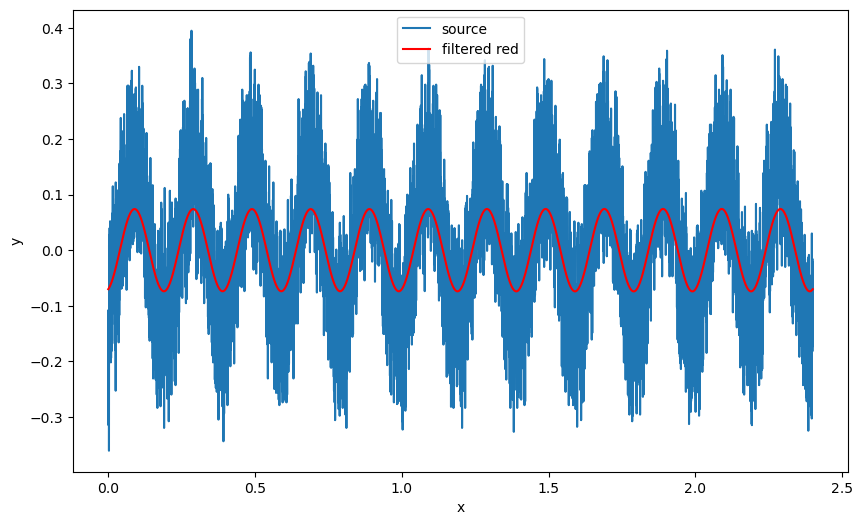

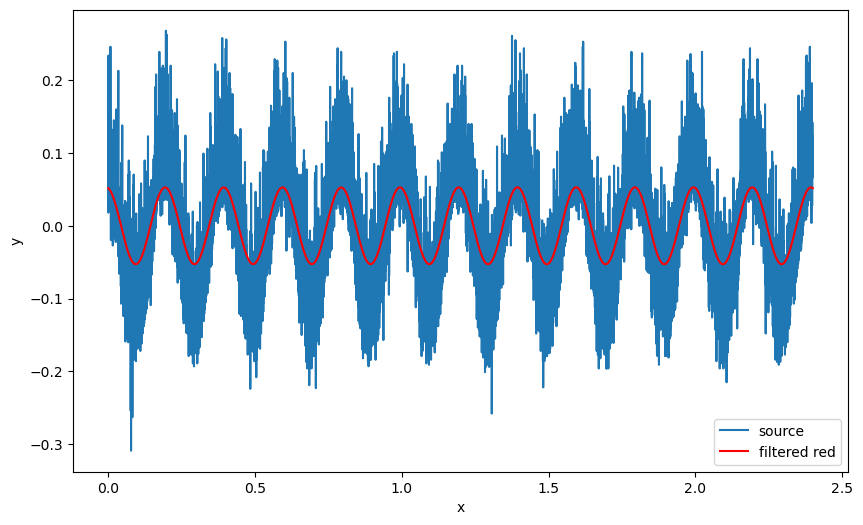

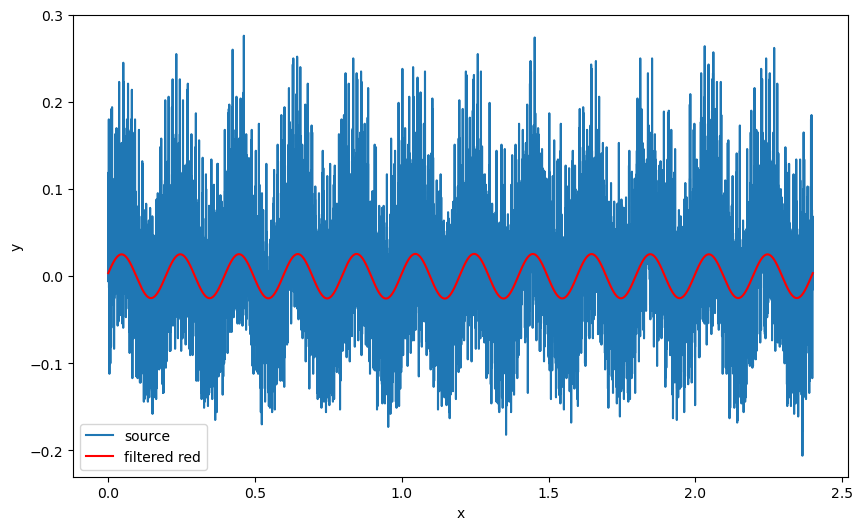

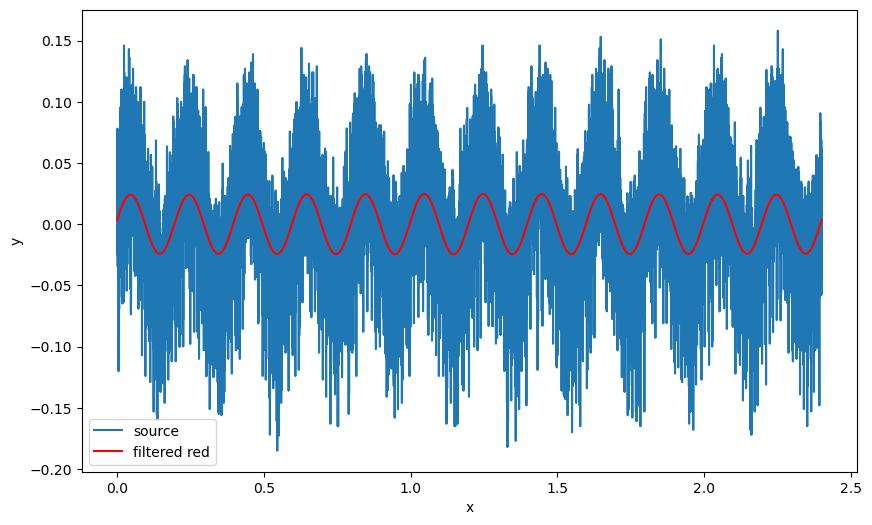

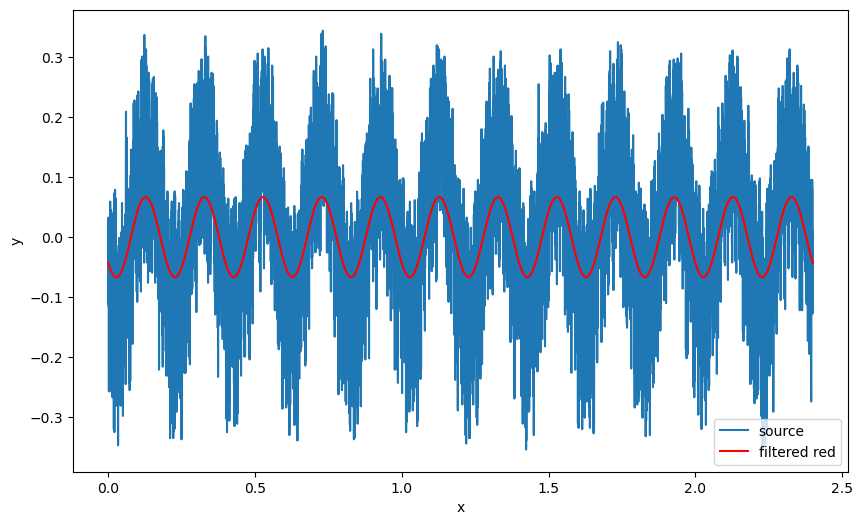

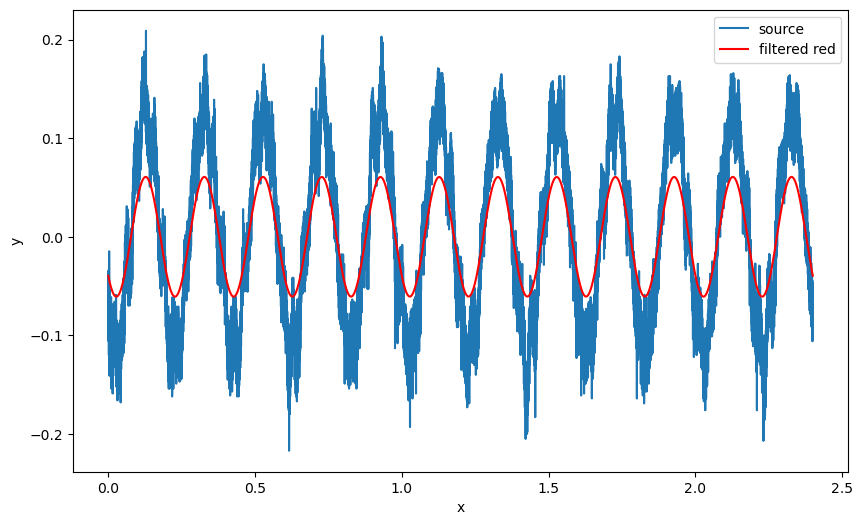

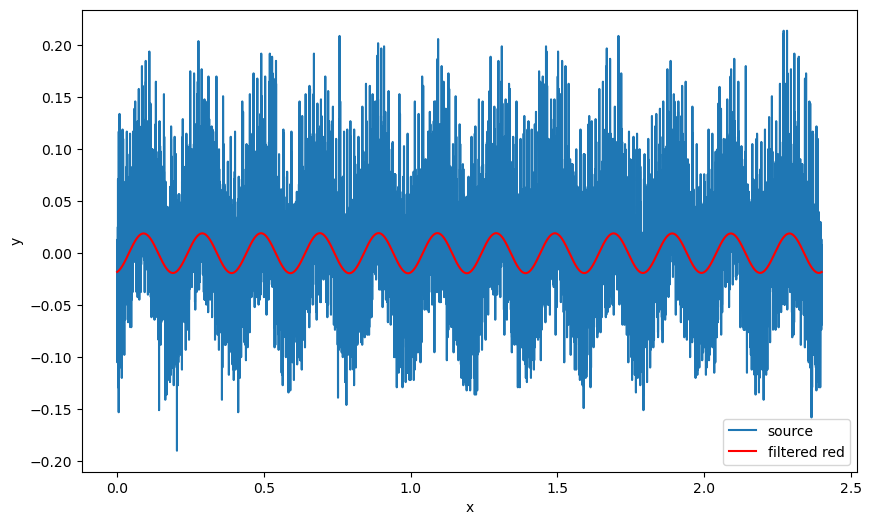

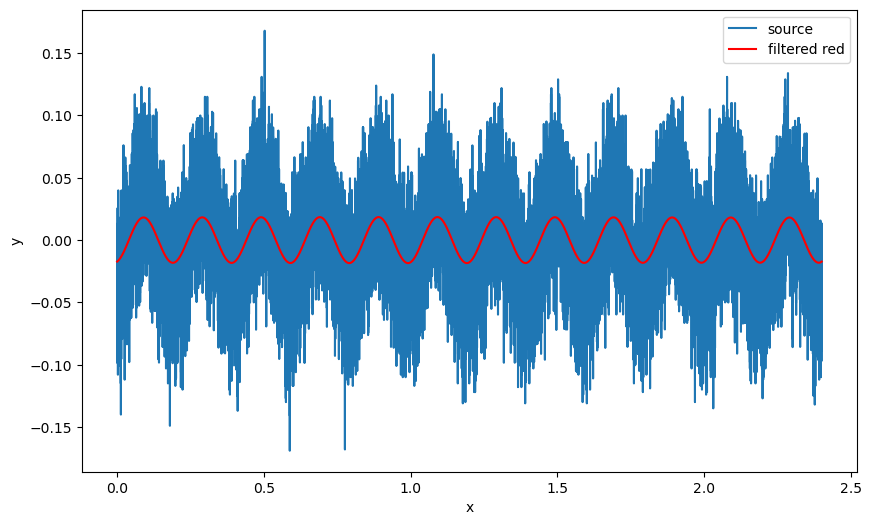

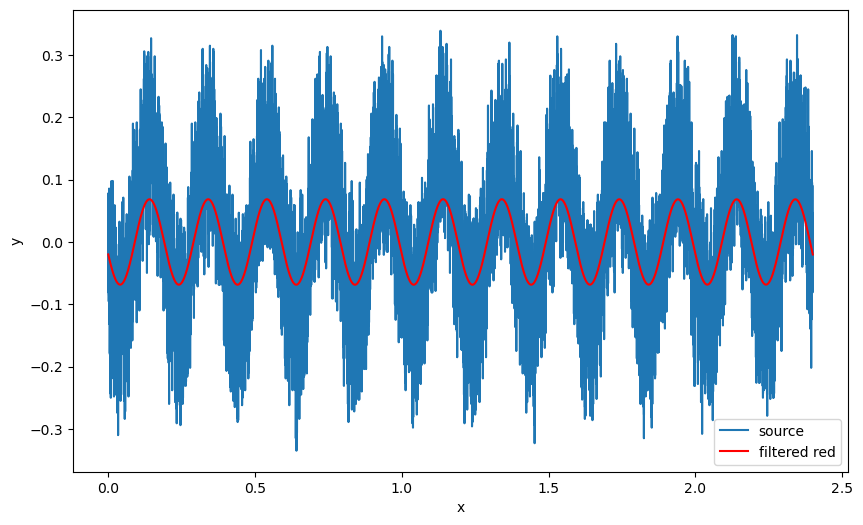

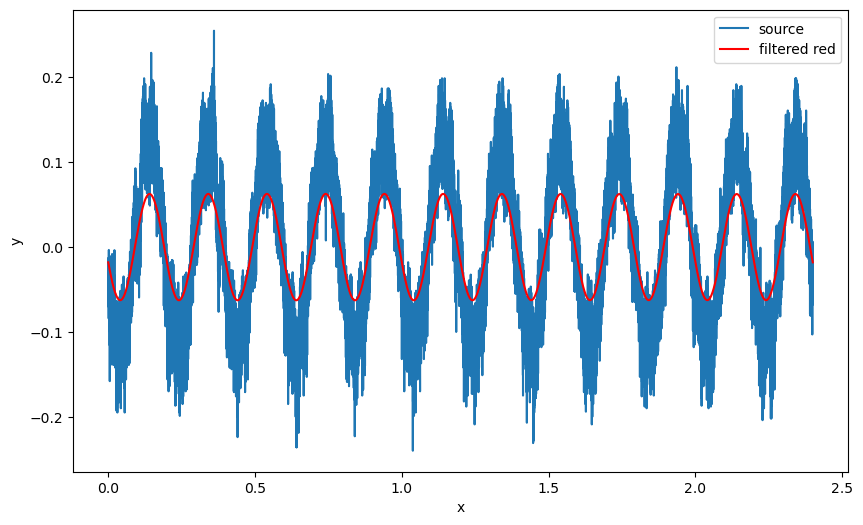

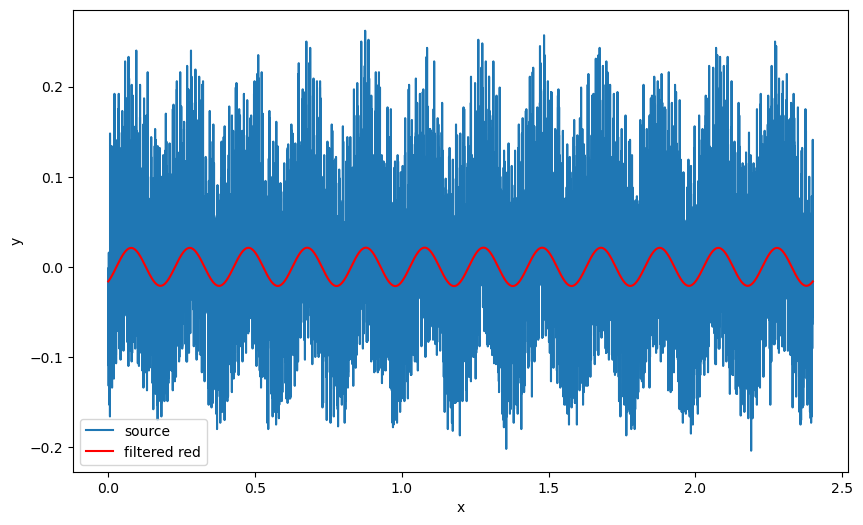

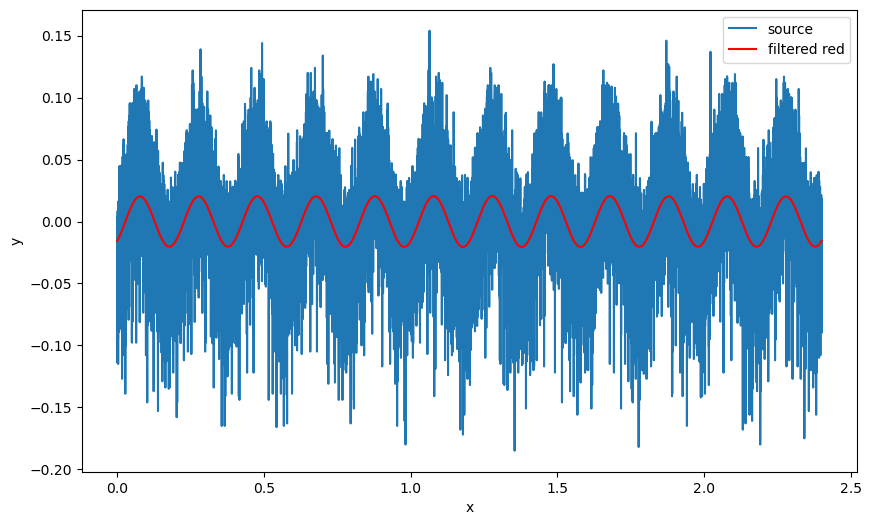

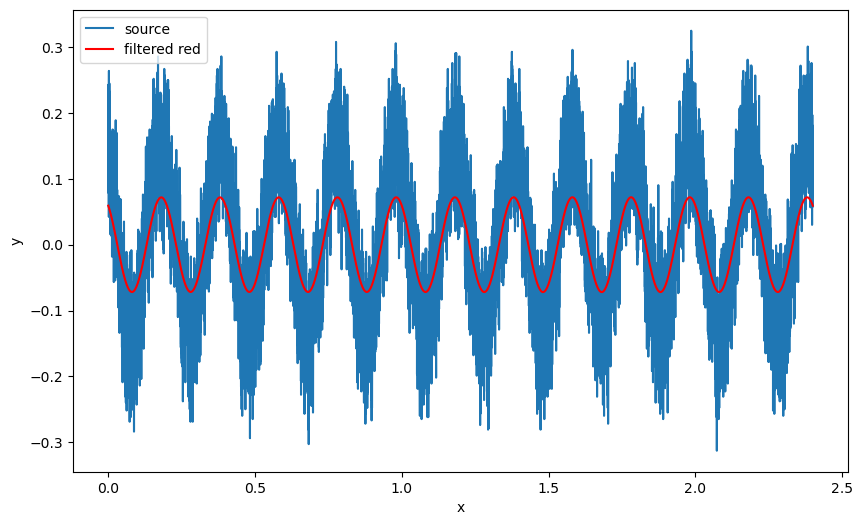

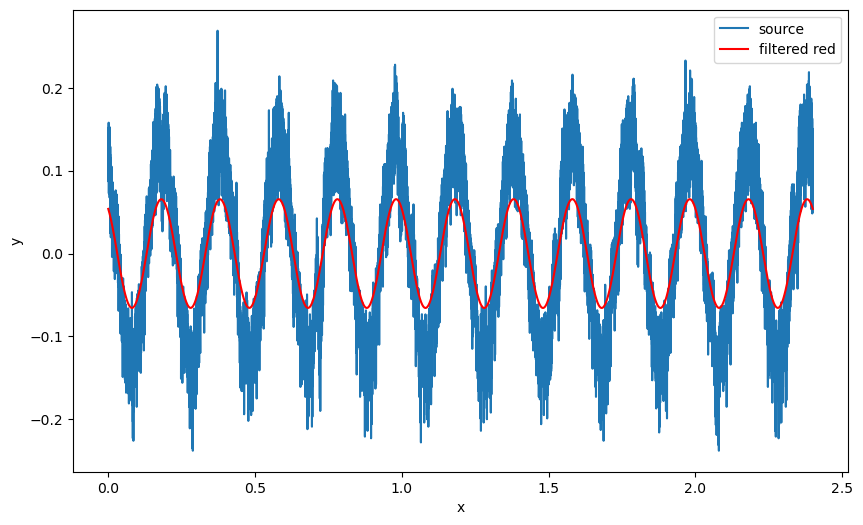

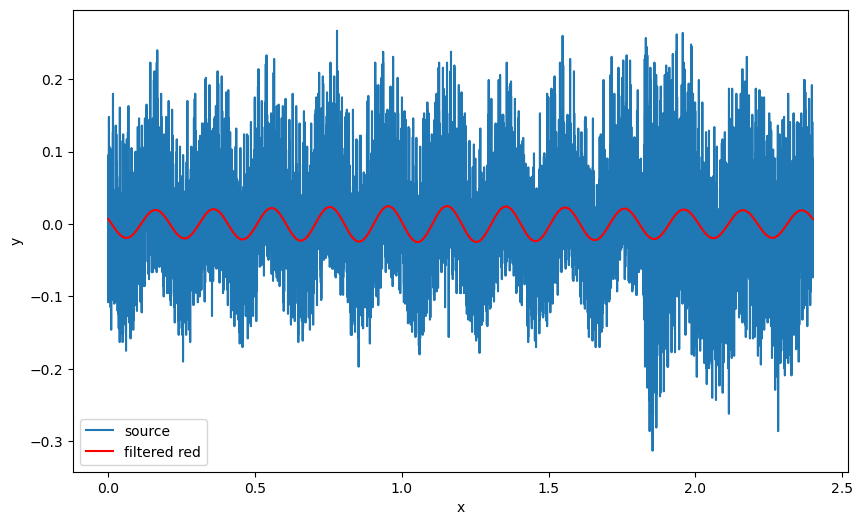

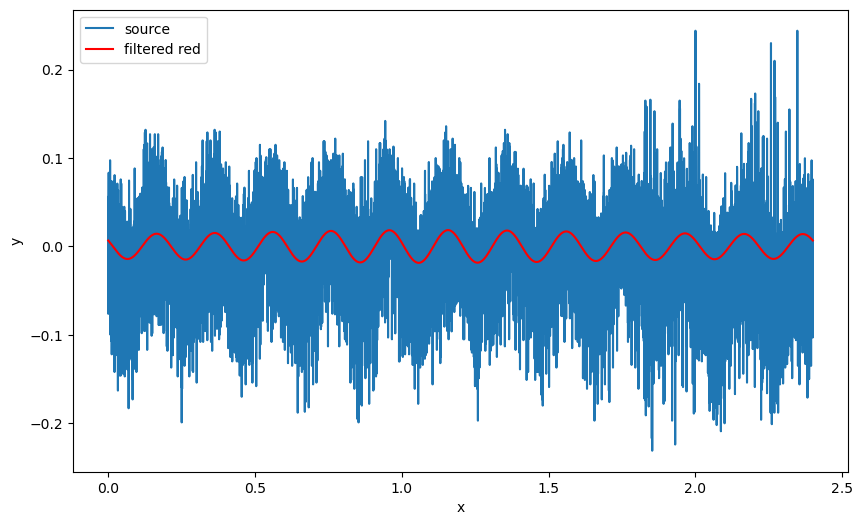

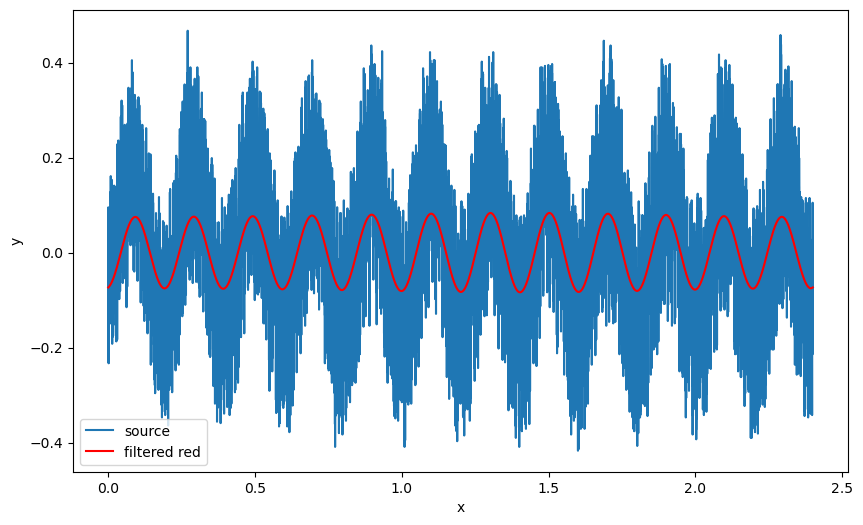

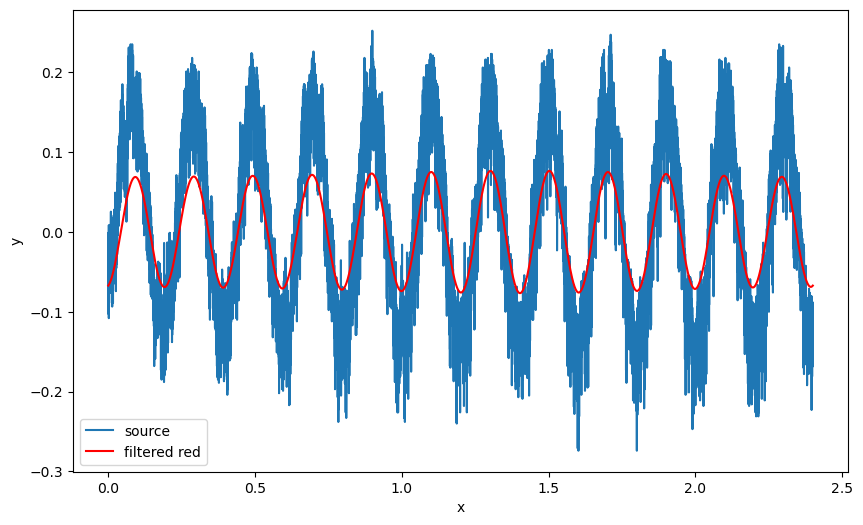

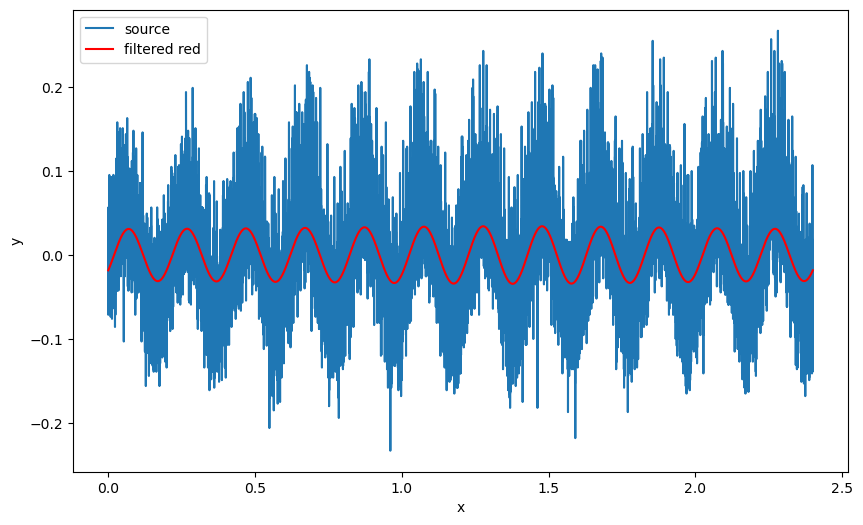

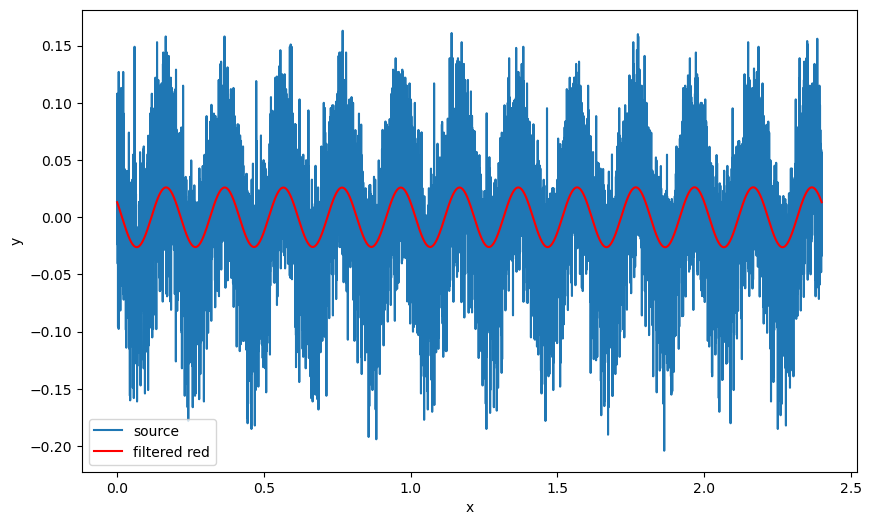

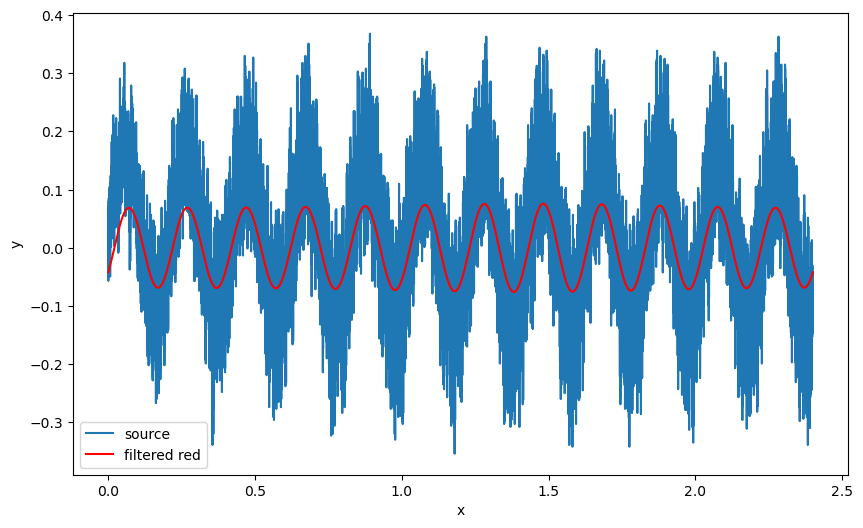

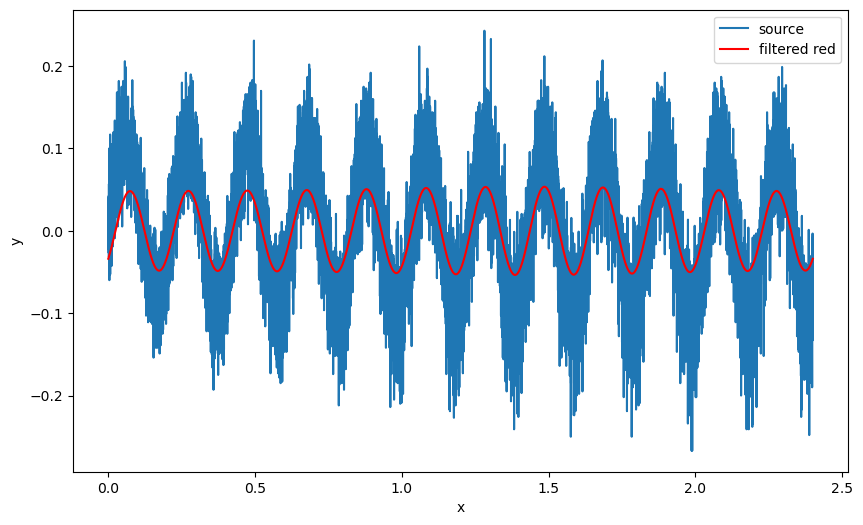

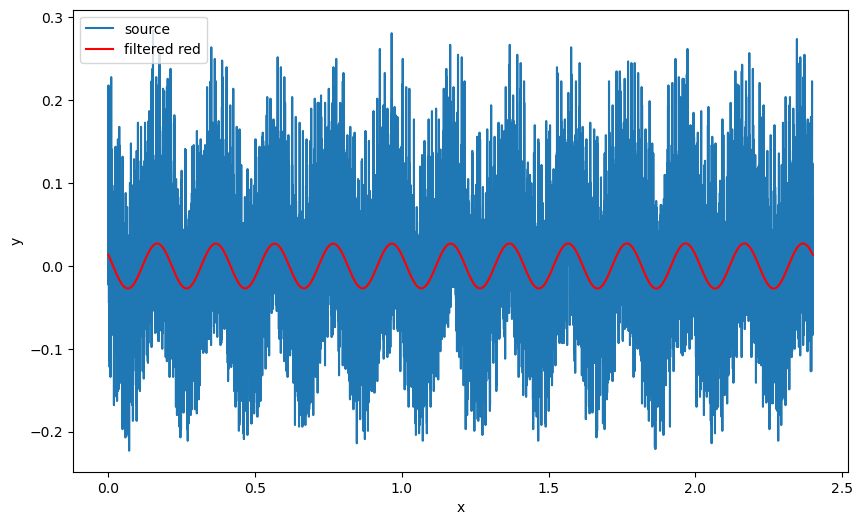

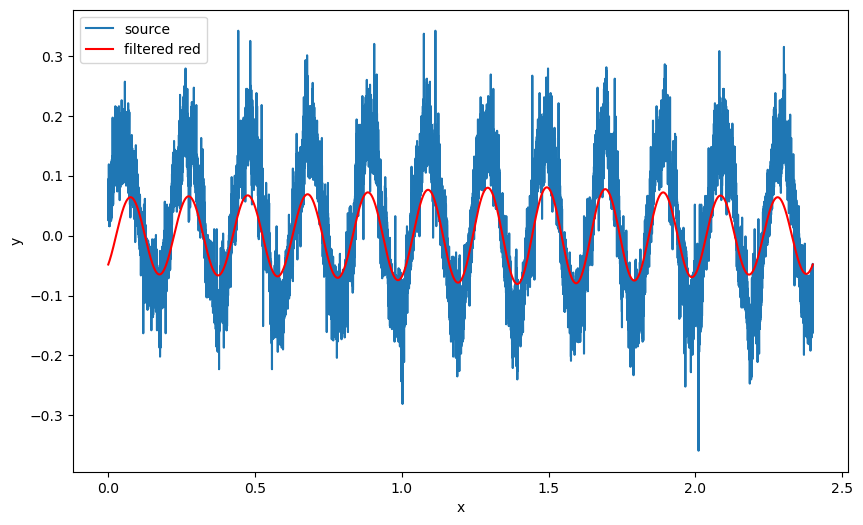

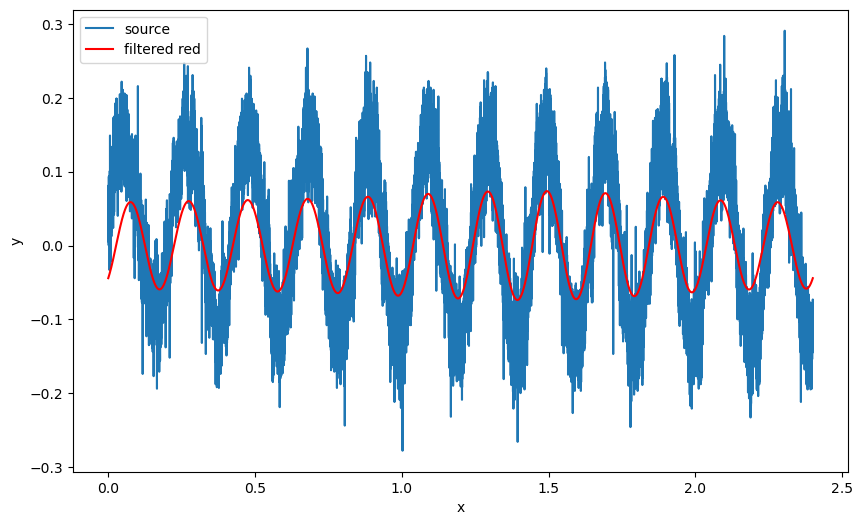

ValueError: x and y must have same first dimension, but have shapes (6500001,) and (6000000,)

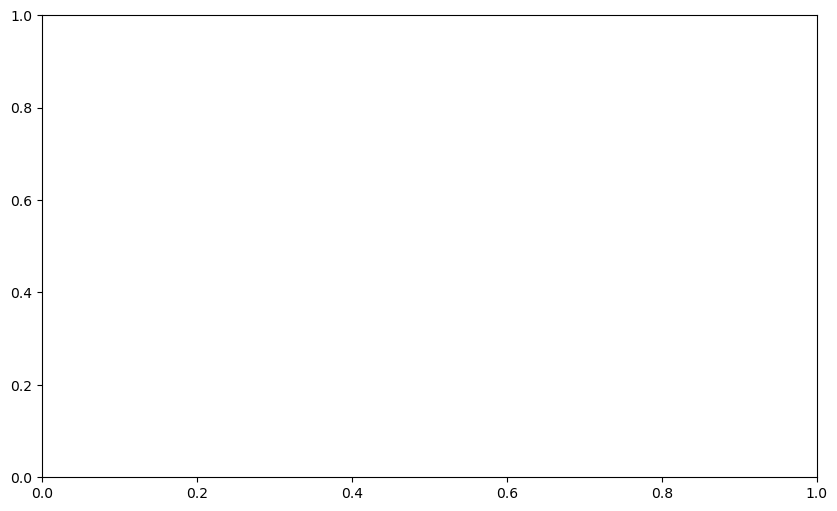

In [29]:
filtered_signals = []

for i in range(len(data_list)):
    filtered_signal = ifft_filter(fft_results[i], fft_freqs[i], params_b[i] / 2 / np.pi, 1)
    filtered_signals.append(filtered_signal)
    plot_ifft_figure(data_list[i][0], data_list[i][1], filtered_signal)

In [ ]:
# # 计算移动平均
# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# # 应用移动平均
# window_size = 5
# y_smoothed = moving_average(y, window_size)

In [ ]:
# def func_curve(x, y, b):
#     # 模型函数f(x) = asin(bx+c)
#     def func_model(x, a, c):
#         return a * np.sin(b * x + c)

#     # 进行曲线拟合
#     initial_guess = [0.3, 1]
#     popt, pcov = curve_fit(func_model, x, y, initial_guess)
#     print('popt: ', popt)
    
#     return popt, pcov

In [ ]:
# popts = []
# for i in range(len(data_list)):
#     popt, pcov = func_curve(data_list[i][0], data_list[i][1], params_b[i])
#     popts.append(popt)

In [30]:
def plot_curve(x, y, b, popt):
    # 模型函数f(x) = asin(bx+c)
    def func_model(x, a, c):
        return a * np.cos(b * x + c)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='source')
    plt.plot(x, func_model(x, *popt), label='fitting', color='red')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [ ]:
# for i in range(len(data_list)):
#     plot_curve(data_list[i][0], data_list[i][1], params_b[i], popts[i])

In [31]:
# 计算滤波后逆FFT得到的a
ifft_fit_popts = []
# print(len(data_list))
# print(len(filtered_signals))
for i in range(len(filtered_signals)):
    max_a = 0
    max_a_index = 0
    for j in range(len(filtered_signals[i])):
        temp_y = filtered_signals[i][j]
        if temp_y > max_a:
            max_a = temp_y
            max_a_index = j
    
    max_x = data_list[i][0][max_a_index]
    c = - max_x * params_b[i]     # 取最大值时 bx+c = 0

    ifft_fit_popts.append([max_a, c])

31
26


In [ ]:
for i in range(len(data_list)):
     plot_curve(data_list[i][0], data_list[i][1], params_b[i], ifft_fit_popts[i])
     plot_curve(data_list[i][0], data_list[i][1], params_b[i], [ifft_fit_popts[i][0], phases[i]])

In [32]:
# 保存拟合结果
with open('fit_result.txt', 'w+', encoding="utf-8") as f:
    for i in range(len(filtered_signals)):
        f.write(f" {file_names[i][len(root_dir):]} : \n")
        f.write(f" fft + ifft fit : \n f = {ifft_fit_popts[i][0]} *cos( {params_b[i]} *x + {phases[i]} )\n\n\n")
        # f.write(f" fft + opt fit : \n f = {popts[i][0]} *sin( {params_b[i]} *x + {popts[i][1]} )\n\n")

In [ ]:
# # 可视化FFT
# plt.figure(figsize=(12, 6))

# # 绘制原始信号
# plt.subplot(2, 1, 1)
# plt.plot(x, y)
# plt.title("原始信号")
# plt.xlabel("时间 (秒)")
# plt.ylabel("振幅")

# # 绘制 FFT 结果
# plt.subplot(2, 1, 2)
# plt.plot(fft_freq, np.abs(fft_result))
# plt.title("FFT 结果")
# plt.xlabel("频率 (Hz)")
# plt.ylabel("振幅")
# plt.xlim(0, 100)  # 限制 x 轴范围以更好地查看结果